# Problem Set 4 CS129.18

## Requirements


>Geospatial Analytics is a domain heavily used in corporate and business data science. It's used for demand-forecasting, real-estate prediction, population estimation, and optimal route planning..

Using the lessons on DBSCAN, and the other resource notebooks, show the following in this Jupyter Notebook.

Write your answers down as Markdown cells or comments in the code.

1. What are the top 3 most common coffee places? ( 1pt )

2. What is the latitude variance and longitude variance, and explain why these variances are different. ( 3pts )

3. Explain what KMeans intertia is and how different it is from DBSCAN epsilon. ( 4pts )

4. Cluster the locations data with DBSCAN. ( 5pts )

5. Present an analysis of the data following the DBSCAN results. ( 7pts )
 - explain what the clusters mean
 - what does the # of clusters tell us
 - what is this information useful for





-----


Bonus 1 : What is your favorite coffee shop? (1pt)


Bonus 2 : Run everything on your own geospatial dataset, and answer the same questions listed above. (5pts)
Use this: https://developer.foursquare.com/docs/resources/categories
 
----

**Submit this file on Moodle on the submission link I will provide. This is due October 25 12nn.**

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import folium
from folium import plugins
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import foursquare

# Make the graphs a bit prettier, and bigger
# pd.set_option('display.mpl_style', 'default')
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

In [3]:
# # This assigns the coffeeshops data to a dataframe object that maps to the "df" variable
# df = pd.read_csv("data/coffeeshops.csv")
# df = df.drop_duplicates()

In [4]:
# Construct the client object
client = foursquare.Foursquare(client_id='ZGB2TJEX3V0TRSV0IG2F2FKFX21VNB2ZEG5LUO02CXD5M4B1', 
                               client_secret='SYU4AHIKV2ZTDIIXURU3441RJRVNRFF04OZE4WKOHWDCYWL3')

# Build the authorization url for your app
auth_uri = client.oauth.auth_url()

In [5]:
# init topics
topics = ["mexican fast food", "mexican", "burrito", "mexican food", "tacos", "mexican restaurant"]
# topics = ['school', 'university', 'institution', 'college']
# topics = ['transportation', 'transpo', 'commute', 'commuting', 'jeep', 'jeepney', 'bus', 'tricycle']

response = [client.venues.search(params={'query': topic, 
                                         'near': 'Manila, Philippines',
                                        'radius': 10000,
                                        'limit': 30, 
                                        'intent': "browse", 
                                        'categoryId': '4bf58dd8d48988d1c1941735'})
            for topic in topics]

In [29]:
import pprint

print(f'\nresponse length = {len(response)}\n')
pprint.pprint(response[0]['venues'][:2])


response length = 6

[{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/taco_',
                           'suffix': '.png'},
                  'id': '4bf58dd8d48988d151941735',
                  'name': 'Taco Place',
                  'pluralName': 'Taco Places',
                  'primary': True,
                  'shortName': 'Tacos'}],
  'hasPerk': False,
  'id': '57e779e7498e669423021580',
  'location': {'address': '120 A Roces Ave',
               'cc': 'PH',
               'city': 'Quezon City',
               'country': 'Pilipinas',
               'crossStreet': 'T Morato',
               'formattedAddress': ['120 A Roces Ave (T Morato)',
                                    'Quezon City',
                                    'Quezon City',
                                    'Pilipinas'],
               'labeledLatLngs': [{'label': 'display',
                                   'lat': 14.628772,
                                   'lng': 121.032775}

In [7]:
data_list = []
for x in range(len(response)):
    try:
        for i in range(len(response[x]["venues"])):
            poi_id =  response[x]["venues"][i]["id"]
            poi_name =  response[x]["venues"][i]["name"]
            poi_lat =  response[x]["venues"][i]["location"]["lat"]
            poi_lng =  response[x]["venues"][i]["location"]["lng"]
            data_list.append([poi_id, poi_name, poi_lat, poi_lng])
    except KeyError:
        pass

df = pd.DataFrame(data_list, columns=["id", "name", "lat", "lng"])
df = df.drop_duplicates()
df["name"] = df['name'].str.lower()

In [8]:
df.describe()

,lat,lng
count,74.000000,74.000000
mean,14.588890,121.032290
std,0.036413,0.025491
min,14.521225,120.961750
25%,14.559249,121.019454
50%,14.579995,121.035238
75%,14.623397,121.053957
max,14.663393,121.071184


## 1. What are the top 3 most common Mexican restaurants? ( 1pt )
---

<AxesSubplot:title={'center':'\nTop 20 Mexican Restaurants by Number of Branches\n'}>

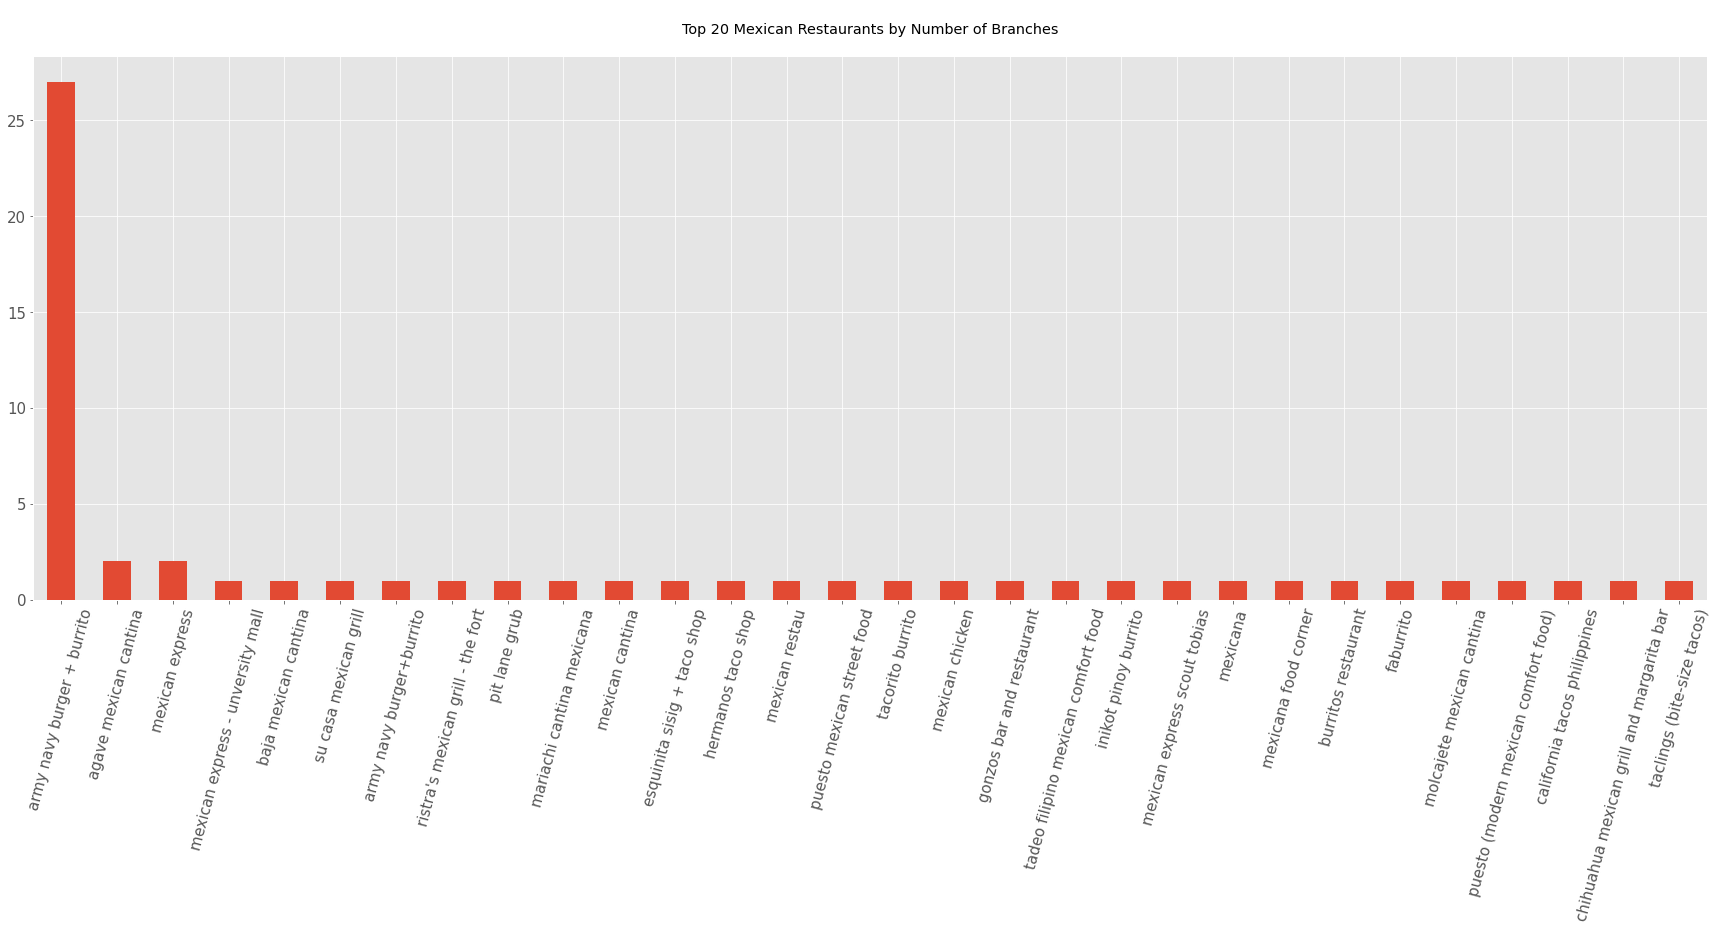

In [9]:
fig, ax = plt.subplots()
df['name'].value_counts().head(30).plot(ax=ax, kind='bar', \
                                        title ="\nTop 20 Mexican Restaurants by Number of Branches\n",figsize=(30,10), fontsize=15, rot=75)

In [10]:
basemap = folium.Map(location=[14.5562297,121.0204097], tiles="cartodbdark_matter", zoom_start=15)

for index, row in df.iterrows():
    folium.CircleMarker([row["lat"], row["lng"]], radius=5,
        popup = folium.Popup(row["name"] + '\n' + str(row["lat"]) + " " + str(row["lng"]), parse_html=True),
    fill=True).add_to(basemap)
    
# basemap.save('fastfood.html')

basemap

## 2. What is the latitude variance and longitude variance, and explain why these variances are different. ( 3pts )
---

In [11]:
df.var()

lat    0.001326
lng    0.000650
dtype: float64

The difference between the variances of the longitude and latitude coordinates is influenced by the distribution of the data points across Metro Manila. From the data above, it can be inferred that the higher latitude variance is a result of majority of the data points being more spread out 

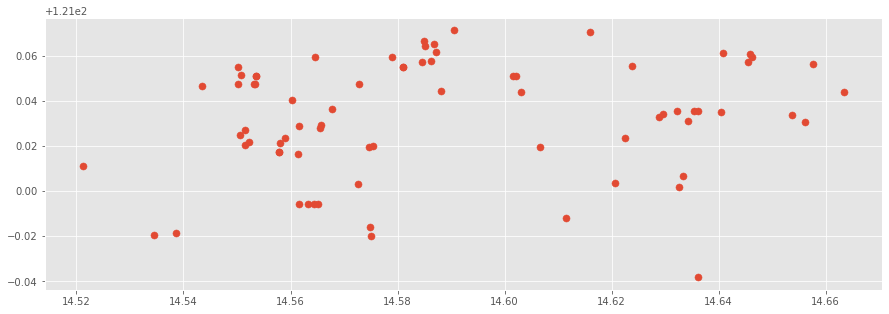

In [12]:
X = np.array(df[["lat", "lng"]].values.tolist())
plt.scatter(X[:, 0], X[:, 1], s=50)

In [13]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

df["cluster"] = y_kmeans

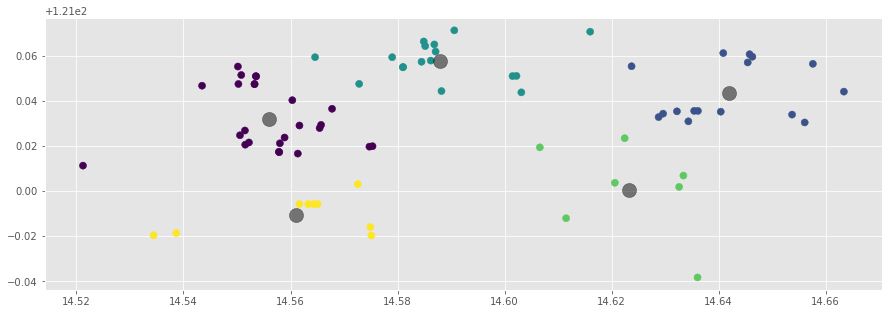

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [15]:
df.head()

,id,name,lat,lng,cluster
0,57e779e7498e669423021580,puesto mexican street food,14.628772,121.032775,1
1,5c0bac8fa6031c002c89aeac,tadeo filipino mexican comfort food,14.632198,121.035319,1
2,5997c24bccad6b5a97fef5db,puesto (modern mexican comfort food),14.645772,121.060616,1
3,4e48d861a809fb2fa40a2774,mexicana food corner shangri-la,14.580992,121.054808,2
4,5180ec0f498eed6d5ca6dc31,mexicana food corner,14.581033,121.054969,2


In [16]:
palette = sns.color_palette("colorblind", 5).as_hex()
palette

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc']

In [17]:
color_getter = lambda x: palette[int(x)]
df["color"] = df["cluster"].map(color_getter)
df.head()

,id,name,lat,lng,cluster,color
0,57e779e7498e669423021580,puesto mexican street food,14.628772,121.032775,1,#de8f05
1,5c0bac8fa6031c002c89aeac,tadeo filipino mexican comfort food,14.632198,121.035319,1,#de8f05
2,5997c24bccad6b5a97fef5db,puesto (modern mexican comfort food),14.645772,121.060616,1,#de8f05
3,4e48d861a809fb2fa40a2774,mexicana food corner shangri-la,14.580992,121.054808,2,#029e73
4,5180ec0f498eed6d5ca6dc31,mexicana food corner,14.581033,121.054969,2,#029e73


In [18]:
basemap = folium.Map(location=[14.5562297,121.0204097], tiles="cartodbdark_matter", zoom_start=15)

for index, row in df.iterrows():
    folium.CircleMarker([row["lat"], row["lng"]], radius=5,
        fill=True,
        color =row["color"],
#         popup = folium.Popup(row["name"], parse_html=True),
        popup = folium.Popup(row["name"] + '\n' + str(row["lat"]) + " " + str(row["lng"]), parse_html=True),
        fill_color=row["color"]).add_to(basemap)
    
# basemap.save('coffeeshops.html')

basemap

In [19]:
sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)

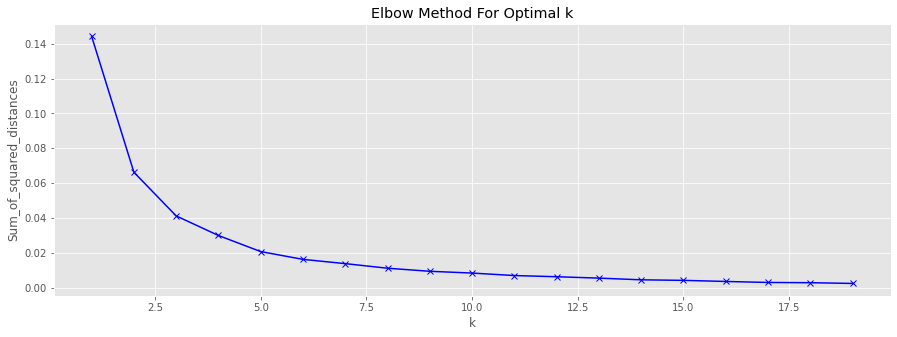

In [20]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## 3. Explain what KMeans inertia is and how different it is from DBSCAN epsilon. ( 4pts )
---

Based on the scikit-learn documentation, the KMeans inertia is recognized as a benchmark to determine if a cluster is optimal or not. The established rule of thumb is that a lower inertia value translates to an objectively performant cluster given that the samples are separated in n groups of equal variance. In essence, the inertia value is the sum of squared distances of all data points within a cluster, also known as intracluster distance. However, it also poses certain issues. One prominent disadcantage is that it assumes that clusters are convex and isotropic, which causes it to perform poorly when clusters vary in size and density. 

On the other hand, DBSCAN's epsilon value is a measure of distance used to locate nearby data points. According to hdbscan documentation, it enables the algorithmn to survey the domain or radius of every data point to check its density in terms of points. This enables the algorithm to disregard outliers that are outside the radius of a data point, dictated by its epsilon value. Both algorithms are fundamentally different in that KMeans is a distance-based clustering algorithm whereas DBSCAN is a density-based algorithm.

### References: 
- https://scikit-learn.org/stable/modules/clustering.html
- https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
- https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages
- https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

## 4. Cluster the locations data with DBSCAN. ( 5pts )
---

In [21]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.005, min_samples=4).fit(X)
y_dbscan = dbscan.labels_
y_dbscan

array([ 0,  0,  1,  2,  2,  3,  0,  7,  1,  4,  7, -1, -1,  3,  5, -1,  6,
       -1, -1,  7, -1,  4,  1,  1, -1, -1, -1, -1,  6,  2,  0, -1, -1,  5,
       -1, -1,  2,  6,  4, -1,  0, -1, -1,  7,  4,  4, -1, -1, -1,  6,  3,
       -1, -1,  2, -1, -1,  4,  3, -1, -1, -1,  5,  4, -1, -1,  5, -1, -1,
       -1,  0, -1, -1,  6,  0], dtype=int64)

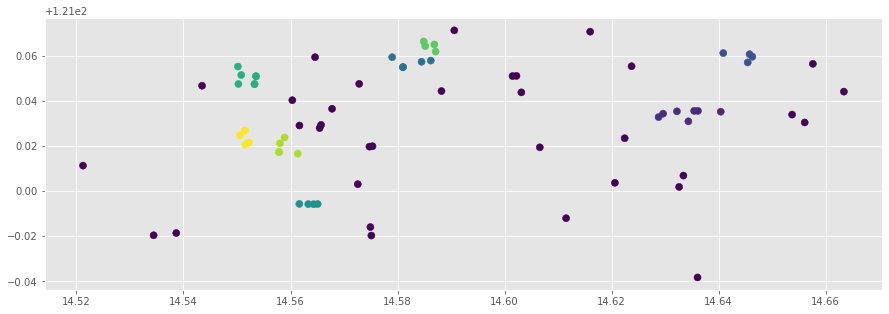

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y_dbscan, s=50, cmap='viridis')

In [23]:
df["dbscan_cluster"] = y_dbscan
palette = sns.color_palette("colorblind", len(y_dbscan)).as_hex()
color_getter = lambda x: palette[int(x)]
df["db_color"] = df["dbscan_cluster"].map(color_getter)
df.head()

,id,name,lat,lng,cluster,color,dbscan_cluster,db_color
0,57e779e7498e669423021580,puesto mexican street food,14.628772,121.032775,1,#de8f05,0,#0173b2
1,5c0bac8fa6031c002c89aeac,tadeo filipino mexican comfort food,14.632198,121.035319,1,#de8f05,0,#0173b2
2,5997c24bccad6b5a97fef5db,puesto (modern mexican comfort food),14.645772,121.060616,1,#de8f05,1,#de8f05
3,4e48d861a809fb2fa40a2774,mexicana food corner shangri-la,14.580992,121.054808,2,#029e73,2,#029e73
4,5180ec0f498eed6d5ca6dc31,mexicana food corner,14.581033,121.054969,2,#029e73,2,#029e73


In [24]:
df = df[df["dbscan_cluster"] > -1]

In [25]:
basemap = folium.Map(location=[14.5562297,121.0204097], tiles="cartodbdark_matter", zoom_start=15)

for index, row in df.iterrows():
    folium.CircleMarker(
        [row["lat"], row["lng"]], radius=5,
        fill = True,
        color = row["db_color"],
#         popup = folium.Popup(str(row["lat"]) + " " + str(row["lng"]), parse_html=True),
        popup = folium.Popup(row["name"] + '\n' + str(row["lat"]) + " " + str(row["lng"]), parse_html=True),
        fill_color=row["db_color"]
   ).add_to(basemap)
    
# basemap.save('fast_food_db.html')

basemap

## 5. Present an analysis of the data following the DBSCAN results. ( 7pts )
### - explain what the clusters mean
### - what does the # of clusters tell us
### - what is this information useful for

---

The clusters are the different groups of restaurants that are near each other given the epsilon and the minimum number of samples. The number of clusters essentially denote the number of groups of restaurants that fit the foregoing criteria. One of the ways that his information could be useful is it could benefit individuals or corporations who want to establish new Mexican restaurants in Metro Manila as it provides data on which places have a low, high, and moderate number of Mexican restaurants. 

## Bonus: What is your favorite Mexican restaurant? (1pt)
---

Silantro? Chihuahua?